# Simple Linear Regression - Price of Bitcoin Explained by Adoption Rate (Proxy: Volume)

##### According to the article 'The Fundamental Drivers of Cyrptocurrency Prices', (https://voxeu.org/article/fundamental-drivers-cryptocurrency-prices), Siddharth, Stefanos and George argue that
##### the trustworthiness of the cryptocurrency's blockchain and the adoption of the blockchain are the two key drivers of the prices of cryptocurrency. Due to the lack of market data on adoption
##### rate, I will use the volume as a proxy of adoption rate in order to explore the relation between Bitcoin Prices and Adoption Rates. My analysis will look at the relationship over the period
##### December 23rd, 2019 to December 23rd, 2020.

##### Import Libraries and Dependencies

In [60]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import kurtosis, skew

%matplotlib inline

##### 1. Import Bitcoin-USD datafile (downloaded from yahoo finance: https://finance.yahoo.com/quote/BTC-USD/history?period1=1577124562&period2=1608746962&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [61]:
# Check current working directory
Path.cwd()

WindowsPath('C:/Users/esuba/Linear_Regression')

In [62]:
# Read btc file and index on date
btc_df = pd.read_csv(Path('BTC-USD.csv'), index_col='Date', parse_dates=True)
btc_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,7508.902344,7656.176270,7326.192383,7355.628418,7355.628418,27831788041
2019-12-24,7354.393066,7535.716797,7269.528809,7322.532227,7322.532227,22991622105
2019-12-25,7325.755859,7357.020020,7220.991211,7275.155762,7275.155762,21559505148
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360995


In [63]:
btc_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-19,23132.865234,24085.855469,22826.472656,23869.832031,23869.832031,38487546580
2020-12-20,23861.765625,24209.660156,23147.710938,23477.294922,23477.294922,37844228422
2020-12-21,23474.455078,24059.982422,22159.367188,22803.082031,22803.082031,45852713981
2020-12-22,22794.039063,23789.902344,22430.605469,23783.029297,23783.029297,44171632681
2020-12-23,23527.626953,23999.853516,22992.117188,23626.632813,23626.632813,49100566528


##### 2. Cleanup, Explore and Prepare Datafile

In [64]:
# Inspect column names
btc_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [65]:
# Drop non-essential columns, i.e. Keep 'Adj Close' and 'Volume'
btc_df = btc_df[['Adj Close', 'Volume']]
btc_df.head()

,Adj Close,Volume
Date,,
2019-12-23,7355.628418,27831788041
2019-12-24,7322.532227,22991622105
2019-12-25,7275.155762,21559505148
2019-12-26,7238.966797,22787010034
2019-12-27,7290.088379,22777360995


In [66]:
# Rename 'Adj Close' to 'Clsoe'
btc_df = btc_df.rename(columns = {'Adj Close': 'Close'})
btc_df.head()

,Close,Volume
Date,,
2019-12-23,7355.628418,27831788041
2019-12-24,7322.532227,22991622105
2019-12-25,7275.155762,21559505148
2019-12-26,7238.966797,22787010034
2019-12-27,7290.088379,22777360995


In [67]:
# Check data types
btc_df.dtypes

Close     float64
Volume      int64
dtype: object

In [68]:
# Check for nissing values, NA and NULL
btc_df.isna().sum()

Close     0
Volume    0
dtype: int64

In [69]:
btc_df.isnull().sum()

Close     0
Volume    0
dtype: int64

In [70]:
# Alternate method to check for NAs and NULLs
btc_df.isna().any()

Close     False
Volume    False
dtype: bool

In [71]:
btc_df.isnull().any()

Close     False
Volume    False
dtype: bool

##### 3. Quick exploration of relationship between X and Y variables and visualization

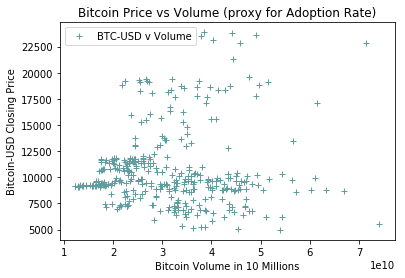

In [72]:
# Plot X independent variable (volume) agains y dependent variable (btc-usd price)
x = btc_df.Volume
y = btc_df.Close

# Create scatter plot
plt.plot(x, y, '+', color='cadetblue', label = 'BTC-USD v Volume')

# Format chart
plt.title('Bitcoin Price vs Volume (proxy for Adoption Rate)')
plt.xlabel('Bitcoin Volume in 10 Millions')
plt.ylabel('Bitcoin-USD Closing Price')
plt.legend()

In [73]:
# Outpout shows a low correlation; we explore with the correlation function
btc_df.corr()

,Close,Volume
Close,1.000000,0.071656
Volume,0.071656,1.000000


In [74]:
print(f"The Correlation between BTC Price and Volume is: {btc_df.corr().Volume[0]}")

The Correlation between BTC Price and Volume is: 0.07165648838763929


##### The correlation between bitcoin price and volume appears extremely low which implies that volume is also a bad proxy for adoption rate

In [75]:
# Descriptive Statistics
btc_df.describe()

,Close,Volume
count,367.000000,3.670000e+02
mean,10684.989089,3.130236e+10
std,3651.193134,1.110057e+10
min,4970.788086,1.225260e+10
25%,8789.077149,2.278219e+10
50%,9653.679688,3.030646e+10
75%,11501.107422,3.862098e+10
max,23869.832031,7.415677e+10


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000260F785E7C8>,
      dtype=object)

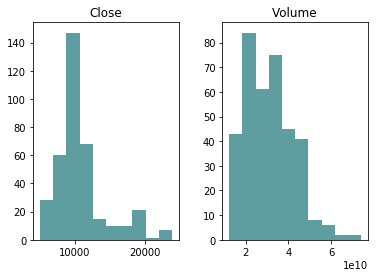

In [76]:
# Use histogram to visualize any outliers
btc_df.hist(grid = False, color = 'cadetblue')

##### Skewed with higher frequency of date on the left of each historgram

In [77]:
# Calculate kurtosis and skewness

# Kurtosis
price_kurtosis = kurtosis(btc_df.Close, fisher = True)
volume_kurtosis = kurtosis(btc_df.Volume, fisher = True)

print(f"Bitcoin Price Excess Kurtosis: {price_kurtosis}")
print(f"Bitcoin Volume Excess Kurtosis: {volume_kurtosis}")

# Skewness
price_skewness = skew(btc_df.Close)
volume_skewness = skew(btc_df.Volume)


print(f"Bitcoin Price Skewness: {price_skewness}")
print(f"Bitcoin Volume Skewness: {volume_skewness}")


Bitcoin Price Excess Kurtosis: 2.2372703933741205
Bitcoin Volume Excess Kurtosis: 0.4776226624025597
Bitcoin Price Skewness: 1.5297677047680003
Bitcoin Volume Skewness: 0.705285041669514


##### Bitcoin Price exhibit more excess kurtosis than the volume, this means that the price has more distribution away from teh mean, hence the higher excess as opposed to volume. While both have excessess kurtosis
##### the histograms also prove that volume has fewer distribution away from the mean than price

##### Similar to kurtosis, price shows far less assementry than volume; similar explanation from kurtosis applies to skewness. THE NUMBERS DON'T LIE

##### 4. Build The Regression Model

In [78]:
# Create the model with scikit-learn
model = LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
X = btc_df[['Volume']].values
y = btc_df[['Close']].values

print(f"Volume: {X[:5]}")
print(f"Bitcoin Price: {y[:5]}")

Volume: [[27831788041]
 [22991622105]
 [21559505148]
 [22787010034]
 [22777360995]]
Bitcoin Price: [[7355.628418]
 [7322.532227]
 [7275.155762]
 [7238.966797]
 [7290.088379]]


In [85]:
# Fit data into the model
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
# Coefficient of the Linear Regression Model
print(model.coef_)

[[2.35692074e-08]]


##### Coefficient if very small

In [87]:
# y Intercept
print(model.intercept_)

[9947.21739296]


In [88]:
# Predicted y values based on X values
predicted_y = model.predict(X)

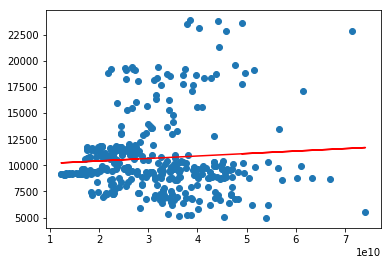

In [89]:
# Plot the results. The best fit is the red line
plt.scatter(X, y)
plt.plot(X, predicted_y, color='red')

In [90]:
# R2 Score the Model
model.score(X, y, sample_weight=None)

0.005134652328047995

##### There is absolutely NO relatonship between Bitcoin price and volume, hence, volume is an incorrect proxy for adoption rate

In [91]:
# Alternate method for calculating intercept and coefficient
model.intercept_[0]

9947.217392957624

In [93]:
model.coef_[0][0]

2.3569207352772504e-08

In [94]:
# Show a sample of the predicted y values
predicted_y[:5]

array([[10603.19057629],
       [10489.11170173],
       [10455.35784021],
       [10484.2891574 ],
       [10484.0617372 ]])

##### 5. Evaluating the Model

In [96]:
# Define the input
X2 = sm.add_constant(X)

# Create an OLS Model
model = sm.OLS(y, X2)

# Fit the data
est = model.fit()


In [97]:
# Confidence Interval @ 95%
est.conf_int()

array([[ 8.82584668e+03,  1.10685881e+04],
       [-1.01996002e-08,  5.73380149e-08]])

In [100]:
print(f"Constant @ 95% Confidence Interval : {est.conf_int()[0]}")
print(f"Bitcoin Price @ 95% Confidence Interval: {est.conf_int()[1]}")

Constant @ 95% Confidence Interval : [ 8825.84667753 11068.58810838]
Bitcoin Price @ 95% Confidence Interval: [-1.01996002e-08  5.73380149e-08]


In [105]:
# Hypothesis Testng
# 1. Null Hypothesis: There is a relatiohship b/w BTC Price and Volume; Reject if p-value < 0.05 as there is strong evidence that the null hypothesis is invalid
# 2. Alternate Hypothesis: There is No relatiohship between BTC-Price and Volume; Accept the alternate hypothesis if p-value < 0.05

# Estimate the p-values
est.pvalues[0]

5.422896498814865e-50

In [106]:
if est.pvalues[0] <= 0.05:
    print(f"The p-value of {est.pvalues[0]} is less than 5%, therefore Reject the Null Hypothesis; There is no relationship between Bitcoin Price and Volume")

The p-value of 5.422896498814865e-50 is less than 5%, therefore Reject the Null Hypothesis; There is no relationship between Bitcoin Price and Volume


In [104]:
est.pvalues[0]

5.422896498814865e-50

In [108]:
##### 5. Summary of Output
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.884
Date:                Wed, 23 Dec 2020   Prob (F-statistic):              0.171
Time:                        18:18:14   Log-Likelihood:                -3529.7
No. Observations:                 367   AIC:                             7063.
Df Residuals:                     365   BIC:                             7071.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9947.2174    570.241     17.444      0.0